In [67]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_log_error

import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor

In [31]:
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_sample = pd.read_csv('sample_submission.csv')

df.head()

,Item_Id,Date,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price
0,IT_1,2007-07-05,0,0,0,0,0.5,2785,4240
1,IT_2,2007-07-05,0,1,0,0,0.7,3574,4756
2,IT_3,2007-07-05,0,103,0,1,1.6,5978,9669
3,IT_4,2007-07-05,0,103,0,0,0.0,5681,8313
4,IT_5,2007-07-05,0,103,0,2,0.0,4924,7257


In [32]:
df.isnull().sum().sort_values(ascending = False)

High_Cap_Price      0
Low_Cap_Price       0
Demand              0
Grade               0
Product_Category    0
Market_Category     0
State_of_Country    0
Date                0
Item_Id             0
dtype: int64

In [33]:
df.describe()

,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price
count,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000
mean,14.278730,198.414064,2.492958,0.652072,71.977414,3500.273525,6349.838028
std,8.760964,169.767862,4.751807,1.032439,927.194052,2188.046803,3652.780956
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,163.000000
25%,3.000000,55.000000,0.000000,0.000000,0.500000,1863.250000,3878.250000
50%,20.000000,129.000000,0.000000,0.000000,2.000000,3124.000000,5552.500000
75%,21.000000,389.000000,1.000000,2.000000,10.175000,4667.500000,7993.750000
max,23.000000,471.000000,17.000000,3.000000,64160.500000,17580.000000,58812.000000


In [34]:
df.dtypes

Item_Id              object
Date                 object
State_of_Country      int64
Market_Category       int64
Product_Category      int64
Grade                 int64
Demand              float64
Low_Cap_Price         int64
High_Cap_Price        int64
dtype: object

In [35]:
df.corr('spearman')

,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price
State_of_Country,1.000000,0.218823,0.156049,-0.239502,0.192885,0.416502,0.117830
Market_Category,0.218823,1.000000,-0.034145,-0.067753,0.004910,0.215140,0.163449
Product_Category,0.156049,-0.034145,1.000000,-0.018791,0.078361,0.162452,0.148881
Grade,-0.239502,-0.067753,-0.018791,1.000000,0.082431,-0.114538,0.086684
Demand,0.192885,0.004910,0.078361,0.082431,1.000000,-0.095373,-0.052390
Low_Cap_Price,0.416502,0.215140,0.162452,-0.114538,-0.095373,1.000000,0.763098
High_Cap_Price,0.117830,0.163449,0.148881,0.086684,-0.052390,0.763098,1.000000


In [36]:
df_test.head()

,Item_Id,Date,State_of_Country,Market_Category,Product_Category,Grade,Demand,High_Cap_Price
0,IT_265079,2014-01-19,0,3,0,0,0.1,5303
1,IT_265087,2014-01-19,0,268,0,2,1.4,10492
2,IT_265107,2014-01-19,0,320,0,0,13.4,24706
3,IT_265139,2014-01-19,17,358,0,3,5.5,23464
4,IT_265142,2014-01-19,18,23,5,2,0.0,6222


In [37]:
df_test.isnull().sum().sort_values(ascending = False)

High_Cap_Price      0
Demand              0
Grade               0
Product_Category    0
Market_Category     0
State_of_Country    0
Date                0
Item_Id             0
dtype: int64

In [38]:
df_test.describe()

,State_of_Country,Market_Category,Product_Category,Grade,Demand,High_Cap_Price
count,5763.000000,5763.000000,5763.000000,5763.00000,5763.000000,5.763000e+03
mean,15.926080,222.169356,4.547978,0.39823,67.695471,3.732109e+04
std,8.122655,145.683245,5.485450,0.81668,486.501858,1.998985e+06
min,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000e+00
25%,11.500000,65.000000,0.000000,0.00000,0.600000,7.244000e+03
50%,21.000000,238.000000,1.000000,0.00000,2.300000,9.364000e+03
75%,21.000000,340.000000,10.000000,0.00000,8.400000,1.256250e+04
max,23.000000,471.000000,17.000000,3.00000,13242.600000,1.517609e+08


Getting dataset ready. As it is already cleaned

In [39]:
x_train = df[['State_of_Country', 'Market_Category', 'Product_Category', 'Grade', 'Demand', 'High_Cap_Price']].to_numpy()
x_test = df_test[['State_of_Country', 'Market_Category', 'Product_Category', 'Grade', 'Demand', 'High_Cap_Price']].to_numpy()

y_train = df['Low_Cap_Price']

assert(x_train.shape[0] == len(y_train))

Linear regression got 99.76 score

In [40]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

LinearRegression()

In [41]:
# Make predictions using the testing set
y_pred = regr.predict(x_test)

In [42]:
# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [ 4.71710976e+01  8.15558902e-01  2.33543554e+01 -4.06070843e+02
 -5.72127521e-02  4.38921543e-01]


Saving the results into csv file

In [49]:
df_submit = pd.DataFrame(list(zip(df_test.Item_Id.to_list(), y_pred)), columns = df_sample.columns)
df_submit.to_csv('submission_1.csv', index = False)
df_submit.head()

,Item_Id,Low_Cap_Price
0,IT_265079,2418.556950
1,IT_265087,4100.027885
2,IT_265107,11192.722895
3,IT_265139,10262.721687
4,IT_265142,2991.952595


Let's try xgboost

In [51]:
data_dmatrix = xgb.DMatrix(data = x_train, label = y_train)

In [55]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0., learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [57]:
xg_reg.fit(x_train, y_train)

preds = xg_reg.predict(x_test)

df_submit = pd.DataFrame(list(zip(df_test.Item_Id.to_list(), preds)), columns = df_sample.columns)
df_submit.to_csv('submission_1.csv', index = False)
df_submit.head()

,Item_Id,Low_Cap_Price
0,IT_265079,2143.656006
1,IT_265087,2130.311523
2,IT_265107,2545.122559
3,IT_265139,2730.035889
4,IT_265142,1678.194580


In [63]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain = data_dmatrix, params = params, nfold = 3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

In [64]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3766.803467,30.199994,3768.614584,65.245564
1,3503.324381,26.413073,3504.839925,67.073383
2,3254.420736,35.293210,3256.782308,58.889273
3,3044.087891,34.158907,3047.980143,64.729246
4,2869.113769,31.726570,2874.060872,65.628333


In [65]:
print((cv_results["test-rmse-mean"]).tail(1))

49    1338.026367
Name: test-rmse-mean, dtype: float64


ImportError: You must install graphviz to plot tree

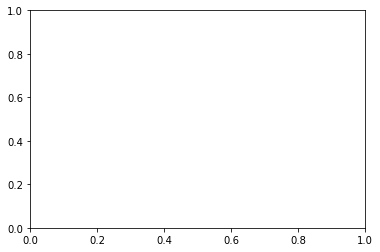

In [66]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

Random Forest got 99.79 score

In [108]:
regr = RandomForestRegressor(max_depth=9, random_state=0, min_samples_leaf = 4, min_samples_split = 5)
regr.fit(x_train, y_train)

preds = regr.predict(x_test)

In [109]:
df_submit = pd.DataFrame(list(zip(df_test.Item_Id.to_list(), preds)), columns = df_sample.columns)
df_submit.to_csv('submission_1.csv', index = False)
df_submit.head()

,Item_Id,Low_Cap_Price
0,IT_265079,3286.092721
1,IT_265087,3017.163102
2,IT_265107,5947.554172
3,IT_265139,6597.757898
4,IT_265142,2081.417090
